# EDA

In [1]:
# Standard library
import pickle
import zipfile
from pathlib import Path

# Third party
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer, MinMaxScaler, PolynomialFeatures

# Authenticate to the Kaggle API for data download
kaggle.api.authenticate()

## 1. Data acquisition

### 1.2. Download

In [2]:
# Create target directory
Path('../data/raw').mkdir(parents=True, exist_ok=True)

# Download latest version
kaggle.api.dataset_download_files(
    'bhanupratapbiswas/superstore-sales',
    path='../data/raw/'
)

Dataset URL: https://www.kaggle.com/datasets/bhanupratapbiswas/superstore-sales


### 1.2. Extract

In [3]:
with zipfile.ZipFile('../data/raw/superstore-sales.zip', mode='r') as archive:
    archive.extract('superstore_final_dataset (1).csv', '../data/raw')

### 1.3. Inspect

In [4]:
data_df = pd.read_csv('../data/raw/superstore_final_dataset (1).csv', encoding='unicode_escape')
data_df.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales
0,1,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/6/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold N Roll Cart System,22.3680


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row_ID         9800 non-null   int64  
 1   Order_ID       9800 non-null   object 
 2   Order_Date     9800 non-null   object 
 3   Ship_Date      9800 non-null   object 
 4   Ship_Mode      9800 non-null   object 
 5   Customer_ID    9800 non-null   object 
 6   Customer_Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal_Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product_ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub_Category   9800 non-null   object 
 16  Product_Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

## 2. Feature distributions

### 2.1. Categorical features

In [6]:
categorical_features = ['Ship_Mode', 'Segment', 'City', 'State',
                        'Postal_Code', 'Region', 'Category', 'Sub_Category']

data_df[categorical_features].nunique()

Ship_Mode         4
Segment           3
City            529
State            49
Postal_Code     626
Region            4
Category          3
Sub_Category     17
dtype: int64

In [7]:
high_cardinality_features = ['City', 'Postal_Code', 'State']

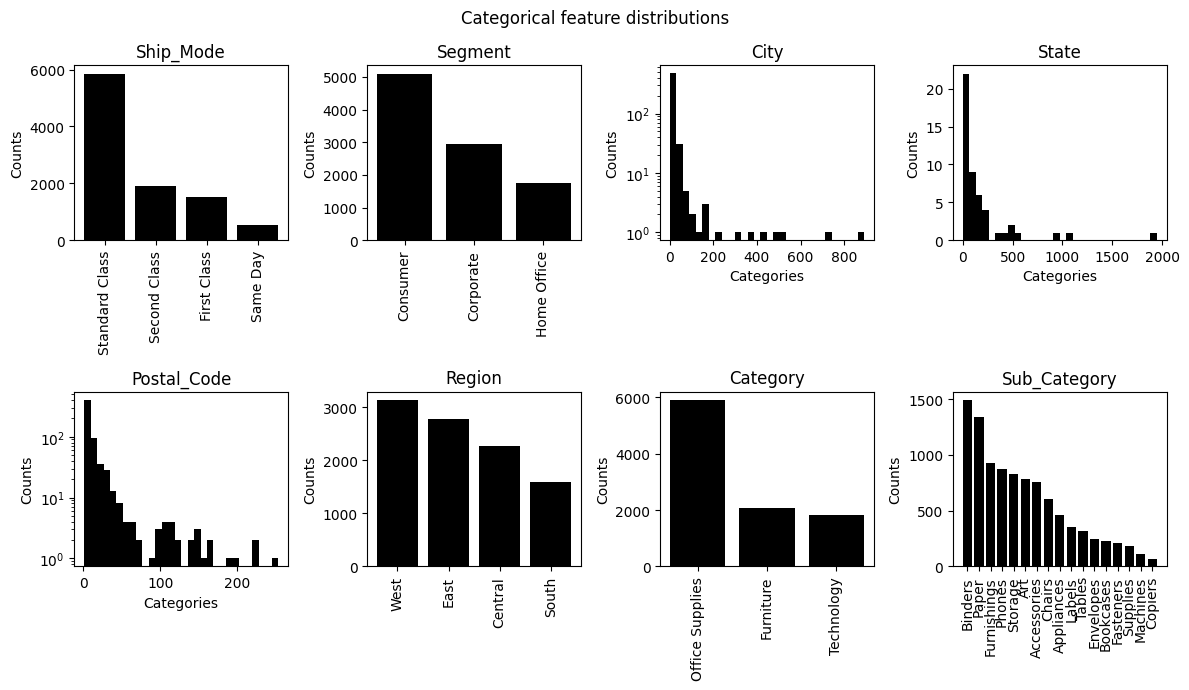

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(12,7))
axs = axs.flatten()

fig.suptitle('Categorical feature distributions')

for i, feature in enumerate(categorical_features):

    level_counts = data_df[feature].value_counts()

    axs[i].set_title(feature)

    if feature in high_cardinality_features:
        axs[i].hist(level_counts.values, bins=30, color='black')
        axs[i].set_xlabel('Categories')

    else:
        axs[i].bar(level_counts.index, level_counts.values, color='black')
        axs[i].tick_params('x', labelrotation=90)

    if feature in ['City', 'Postal_Code']:
        axs[i].set_yscale('log')
    
    axs[i].set_ylabel('Counts')

fig.tight_layout()

### 2.2. Time features

In [9]:
data_df['Order_Date'] = pd.to_datetime(data_df['Order_Date'], format='%d/%m/%Y')
data_df['Ship_Date'] = pd.to_datetime(data_df['Ship_Date'], format='%d/%m/%Y')

#### 2.2.1 Number of orders

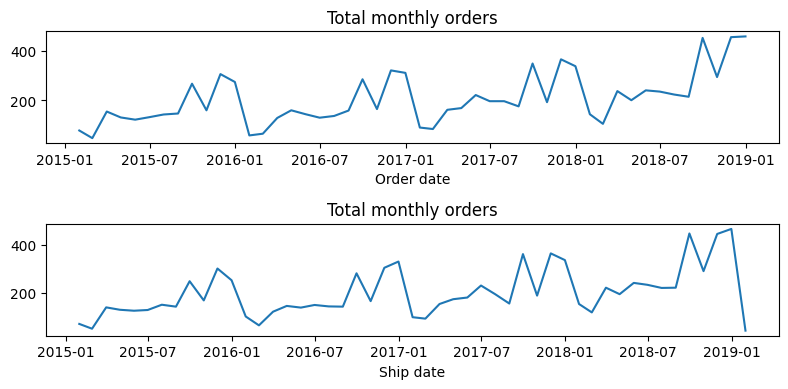

In [10]:
order_date = data_df.groupby('Order_Date').count()['Sales']
ship_date = data_df.groupby('Ship_Date').count()['Sales']

order_date = order_date.resample('ME').sum()
ship_date = ship_date.resample('ME').sum()

fig, axs = plt.subplots(2, 1, figsize=(8, 4))

axs[0].set_title('Total monthly orders')
axs[0].plot(order_date.index, order_date.values)
axs[0].set_xlabel('Order date')

axs[1].set_title('Total monthly orders')
axs[1].plot(ship_date.index, ship_date.values)
axs[1].set_xlabel('Ship date')

fig.tight_layout()

#### 2.2.1. Total sales

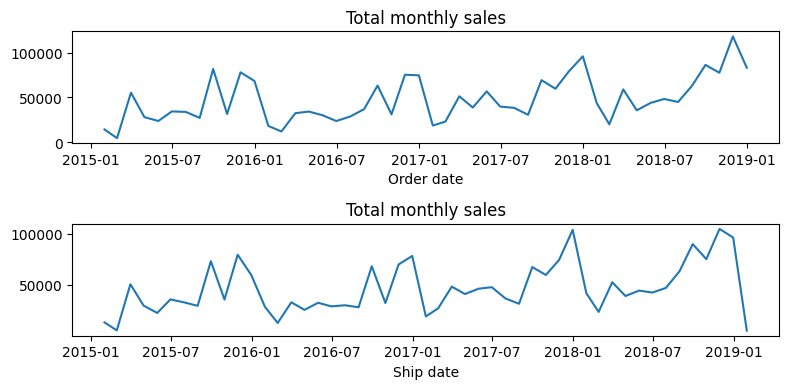

In [11]:
order_date = pd.Series(data_df['Sales'].values, index=data_df['Order_Date'])
ship_date = pd.Series(data_df['Sales'].values, index=data_df['Ship_Date'])

order_date = order_date.resample('ME').sum()
ship_date = ship_date.resample('ME').sum()

fig, axs = plt.subplots(2, 1, figsize=(8, 4))

axs[0].set_title('Total monthly sales')
axs[0].plot(order_date.index, order_date.values)
axs[0].set_xlabel('Order date')

axs[1].set_title('Total monthly sales')
axs[1].plot(ship_date.index, ship_date.values)
axs[1].set_xlabel('Ship date')

fig.tight_layout()

### 2.3. Sales

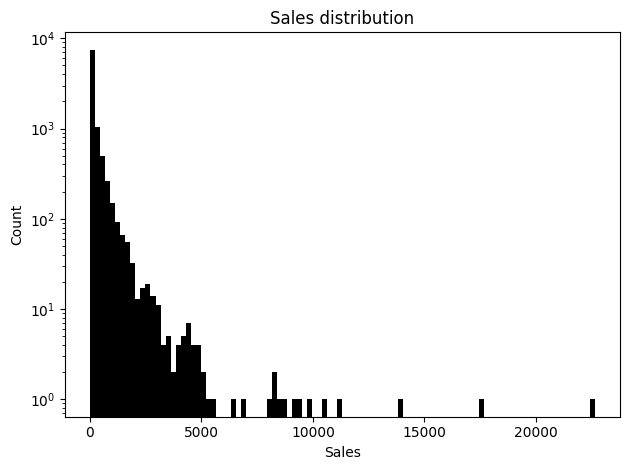

In [12]:
plt.title('Sales distribution')
plt.hist(data_df['Sales'], bins=100, color='black')
plt.yscale('log')
plt.xlabel('Sales')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [13]:
data_df = data_df[data_df['Sales'] < 6000]
data_df.describe()

,Row_ID,Order_Date,Ship_Date,Postal_Code,Sales
count,9785.000000,9785,9785,9774.000000,9785.000000
mean,4901.132448,2017-05-01 08:16:31.885539072,2017-05-05 07:20:36.545733120,55296.609065,214.859828
min,1.000000,2015-01-03 00:00:00,2015-01-07 00:00:00,1040.000000,0.444000
25%,2450.000000,2016-05-25 00:00:00,2016-05-28 00:00:00,23223.000000,17.220000
50%,4902.000000,2017-06-26 00:00:00,2017-06-29 00:00:00,59253.500000,54.224000
75%,7351.000000,2018-05-15 00:00:00,2018-05-19 00:00:00,90008.000000,209.940000
max,9800.000000,2018-12-30 00:00:00,2019-01-05 00:00:00,99301.000000,5443.960000
std,2829.046305,NaN,NaN,32040.502599,447.992694


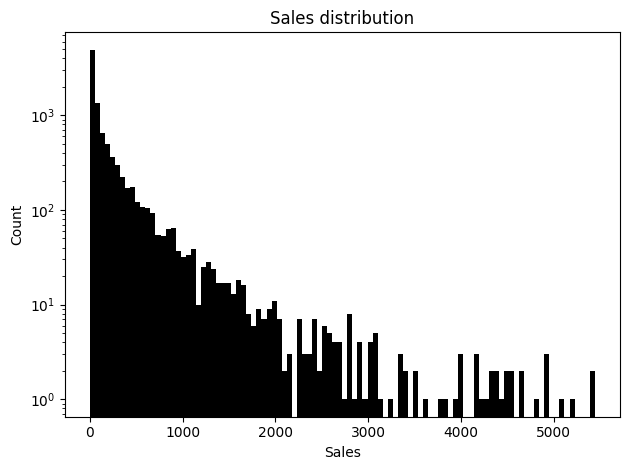

In [14]:
plt.title('Sales distribution')
plt.hist(data_df['Sales'], bins=100, color='black')
plt.yscale('log')
plt.xlabel('Sales')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 2. Feature engineering

### 2.1. Feature selection

In [15]:
categorical_features = ['Ship_Mode', 'Segment', 'City', 'State',
                        'Region', 'Category', 'Sub_Category']

data_df = data_df[categorical_features + ['Sales', 'Order_Date', 'Ship_Date']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9785 entries, 0 to 9799
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Ship_Mode     9785 non-null   object        
 1   Segment       9785 non-null   object        
 2   City          9785 non-null   object        
 3   State         9785 non-null   object        
 4   Region        9785 non-null   object        
 5   Category      9785 non-null   object        
 6   Sub_Category  9785 non-null   object        
 7   Sales         9785 non-null   float64       
 8   Order_Date    9785 non-null   datetime64[ns]
 9   Ship_Date     9785 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 840.9+ KB


### 2.2. Order month & day

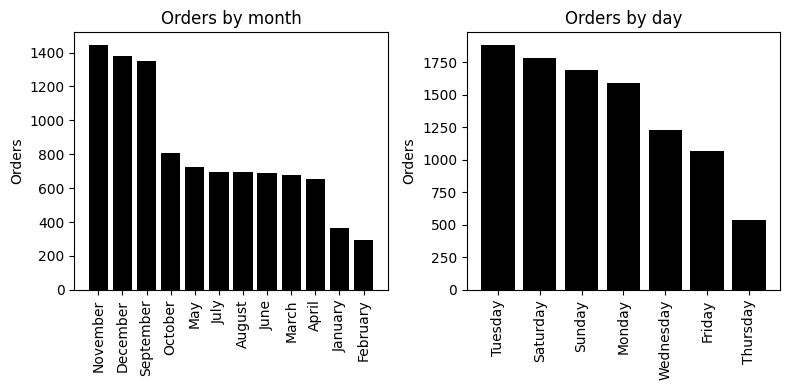

In [16]:
data_df['Order_Month'] = data_df['Order_Date'].dt.month_name()
data_df['Order_Day'] = data_df['Order_Date'].dt.day_name()

month_counts = data_df['Order_Month'].value_counts()
day_counts = data_df['Order_Day'].value_counts()

fig, axs = plt.subplots(1,2, figsize=(8,4))

axs[0].set_title('Orders by month')
axs[0].bar(month_counts.index, month_counts.values, color='Black')
axs[0].tick_params('x', labelrotation=90)
axs[0].set_ylabel('Orders')

axs[1].set_title('Orders by day')
axs[1].bar(day_counts.index, day_counts.values, color='Black')
axs[1].tick_params('x', labelrotation=90)
axs[1].set_ylabel('Orders')

fig.tight_layout()

In [17]:
data_df['Order_Month'] = data_df['Order_Date'].dt.month
data_df['Order_Day'] = data_df['Order_Date'].dt.weekday

### 2.3. Turnaround time

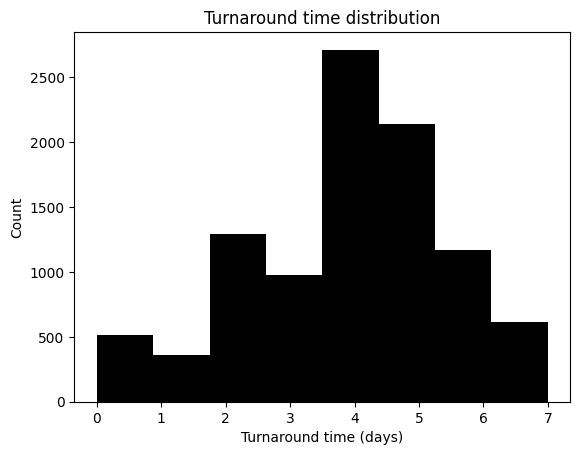

In [18]:
data_df['Turnaround_Time'] = (data_df['Ship_Date'] - data_df['Order_Date']).dt.days

plt.title('Turnaround time distribution')
plt.hist(data_df['Turnaround_Time'], bins=8, color='black')
plt.xlabel('Turnaround time (days)')
plt.ylabel('Count')
plt.show()

In [19]:
data_df.drop(['Order_Date', 'Ship_Date'], axis=1, inplace=True)

## 4. Data preparation

**One-hot encoding** (low cardinality)
1. `Ship_Mode`
2. `Segment`
3. `Region`
4. `Category`

**Ordinal encoding** (high cardinality)

1. `City`
2. `State`
3. `Sub_Category`

**Cyclical encoding** (time)

1. `Order_Day`
2. `Order_Month`

### 4.1. Train-test split

In [20]:
train_df, test_df = train_test_split(data_df, test_size=0.3)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6849 entries, 9087 to 9569
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ship_Mode        6849 non-null   object 
 1   Segment          6849 non-null   object 
 2   City             6849 non-null   object 
 3   State            6849 non-null   object 
 4   Region           6849 non-null   object 
 5   Category         6849 non-null   object 
 6   Sub_Category     6849 non-null   object 
 7   Sales            6849 non-null   float64
 8   Order_Month      6849 non-null   int32  
 9   Order_Day        6849 non-null   int32  
 10  Turnaround_Time  6849 non-null   int64  
dtypes: float64(1), int32(2), int64(1), object(7)
memory usage: 588.6+ KB


### 4.2. One-hot encoding

In [21]:
low_cardinality_features = ['Ship_Mode', 'Segment', 'Region', 'Category']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist')

encoded_training_features = onehot_encoder.fit_transform(train_df[low_cardinality_features])
encoded_testing_features = onehot_encoder.transform(test_df[low_cardinality_features])

encoded_training_df = pd.DataFrame(
    encoded_training_features,
    columns=onehot_encoder.get_feature_names_out()
)

encoded_testing_df = pd.DataFrame(
    encoded_testing_features,
    columns=onehot_encoder.get_feature_names_out()
)

train_df.drop(columns=low_cardinality_features, inplace=True)
test_df.drop(columns=low_cardinality_features, inplace=True)

train_df = pd.concat([encoded_training_df.reset_index(drop=True), train_df.reset_index(drop=True)], axis=1)
test_df = pd.concat([encoded_testing_df.reset_index(drop=True), test_df.reset_index(drop=True)], axis=1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849 entries, 0 to 6848
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ship_Mode_First Class     6849 non-null   float64
 1   Ship_Mode_Same Day        6849 non-null   float64
 2   Ship_Mode_Second Class    6849 non-null   float64
 3   Ship_Mode_Standard Class  6849 non-null   float64
 4   Segment_Consumer          6849 non-null   float64
 5   Segment_Corporate         6849 non-null   float64
 6   Segment_Home Office       6849 non-null   float64
 7   Region_Central            6849 non-null   float64
 8   Region_East               6849 non-null   float64
 9   Region_South              6849 non-null   float64
 10  Region_West               6849 non-null   float64
 11  Category_Furniture        6849 non-null   float64
 12  Category_Office Supplies  6849 non-null   float64
 13  Category_Technology       6849 non-null   float64
 14  City    

### 4.3. Ordinal encoding

In [22]:
high_cardinality_features = ['City', 'State', 'Sub_Category']

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_df[high_cardinality_features] = ordinal_encoder.fit_transform(train_df[high_cardinality_features])
test_df[high_cardinality_features] = ordinal_encoder.transform(test_df[high_cardinality_features])

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849 entries, 0 to 6848
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ship_Mode_First Class     6849 non-null   float64
 1   Ship_Mode_Same Day        6849 non-null   float64
 2   Ship_Mode_Second Class    6849 non-null   float64
 3   Ship_Mode_Standard Class  6849 non-null   float64
 4   Segment_Consumer          6849 non-null   float64
 5   Segment_Corporate         6849 non-null   float64
 6   Segment_Home Office       6849 non-null   float64
 7   Region_Central            6849 non-null   float64
 8   Region_East               6849 non-null   float64
 9   Region_South              6849 non-null   float64
 10  Region_West               6849 non-null   float64
 11  Category_Furniture        6849 non-null   float64
 12  Category_Office Supplies  6849 non-null   float64
 13  Category_Technology       6849 non-null   float64
 14  City    

### 4.4. Cyclical encoding

In [23]:
from sklearn.preprocessing import FunctionTransformer

def _sin(x, period):
    return np.sin(x / period * 2 * np.pi)

def _cos(x, period):
    return np.cos(x / period * 2 * np.pi)

def sin_transform(period):
    return FunctionTransformer(_sin, kw_args={'period':period})

def cos_transform(period):
    return FunctionTransformer(_cos, kw_args={'period':period})

#### 4.4.1. Order day

In [24]:
day_sin_transformer = sin_transform(period=7)
day_cos_transformer = cos_transform(period=7)

train_df['Order_Day_sin'] = day_sin_transformer.fit_transform(train_df['Order_Day'])
test_df['Order_Day_sin'] = day_sin_transformer.transform(test_df['Order_Day'])

train_df['Order_Day_cos'] = day_cos_transformer.fit_transform(train_df['Order_Day'])
test_df['Order_Day_cos'] = day_cos_transformer.transform(test_df['Order_Day'])


#### 4.4.2. Order month

In [25]:
month_sin_transformer = sin_transform(period=12)
month_cos_transformer = cos_transform(period=12)

train_df['Order_Month_Sin'] = month_sin_transformer.fit_transform(train_df['Order_Month'])
test_df['Order_Month_Sin'] = month_sin_transformer.transform(test_df['Order_Month'])

train_df['Order_Month_Cos'] = month_cos_transformer.fit_transform(train_df['Order_Month'])
test_df['Order_Month_Cos'] = month_cos_transformer.transform(test_df['Order_Month'])


In [26]:
train_df.drop(['Order_Month', 'Order_Day'], axis=1, inplace=True)
test_df.drop(['Order_Month', 'Order_Day'], axis=1, inplace=True)

### 4.5. Polynomial features

In [27]:
features = train_df.columns.to_list()
features.remove('Turnaround_Time')
features.remove('Sales')

train_labels = train_df[['Turnaround_Time', 'Sales']].copy()
test_labels = test_df[['Turnaround_Time', 'Sales']].copy()

poly_transformer = PolynomialFeatures()

train_poly = poly_transformer.fit_transform(train_df[features])
train_poly = pd.DataFrame(
    train_poly,
    columns=poly_transformer.get_feature_names_out()
)

test_poly = poly_transformer.transform(test_df[features])
test_poly = pd.DataFrame(
    test_poly,
    columns=poly_transformer.get_feature_names_out()
)

train_df = pd.concat([train_poly.reset_index(drop=True), train_labels.reset_index(drop=True)], axis=1)
test_df = pd.concat([test_poly.reset_index(drop=True), test_labels.reset_index(drop=True)], axis=1)

## 5. Save

In [28]:
Path('../data/processed').mkdir(parents=True, exist_ok=True)

### 5.1. Sales data

In [29]:
sales_data = {
    'training': train_df.drop(['Turnaround_Time'], axis=1),
    'testing': test_df.drop(['Turnaround_Time'], axis=1)
}

with open('../data/processed/sales.pkl', 'wb') as output_file:
    pickle.dump(sales_data, output_file)

### 5.2. Turnaround time data

In [30]:
turnaround_data = {
    'training': train_df.drop(['Sales'], axis=1),
    'testing': test_df.drop(['Sales'], axis=1)
}

with open('../data/processed/turnaround_time.pkl', 'wb') as output_file:
    pickle.dump(turnaround_data, output_file)

### 5.3. Encoders

In [31]:
with open('../models/onehot_encoder.pkl', 'wb') as output_file:
    pickle.dump(onehot_encoder, output_file)

In [32]:
with open('../models/ordinal_encoder.pkl', 'wb') as output_file:
    pickle.dump(ordinal_encoder, output_file)

### 5.4. Transformers

In [33]:
time_transformers = {
    'day_sin': day_sin_transformer,
    'day_cos': day_cos_transformer,
    'month_sin': month_sin_transformer,
    'month_cos': month_cos_transformer
}

with open('../models/time_transformers.pkl', 'wb') as output_file:
    pickle.dump(time_transformers, output_file)

with open('../models/poly_transformer.pkl', 'wb') as output_file:
    pickle.dump(poly_transformer, output_file)